In [17]:
import torch
from llama_moe_rnn import LlamaForCausalLM
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm

In [4]:
def get_similarities(htoh4_0, htoh4_1, h4toh):
    avg_key_0 = htoh4_0.mean(dim=1) # (num_experts, 4h, h)
    avg_key_1 = htoh4_1.mean(dim=1) # (num_experts, h)
    avg_value = h4toh.mean(dim=2) # (num_experts, h)
    normed_key_0 = nn.functional.normalize(avg_key_0, p=2, dim=1)
    normed_key_1 = nn.functional.normalize(avg_key_1, p=2, dim=1)
    normed_value = nn.functional.normalize(avg_value, p=2, dim=1)
    normed_avg_expert = torch.cat([normed_key_0, normed_key_1, normed_value], dim=1)
    avg_expert = torch.cat([avg_key_0, avg_key_1, avg_value], dim=1)
    # 计算 experts 间的平均相似度
    similarity = torch.mm(avg_expert, avg_expert.t()) 
    avg_sim = similarity.mean().item()

    normed_similarity = torch.mm(normed_avg_expert, normed_avg_expert.t())
    normed_avg_sim = normed_similarity.mean().item()
    return avg_sim, normed_avg_sim

In [31]:
ckpt_infos = {}

for ckpt in tqdm([f'0{j}000' for j in range(1, 10)] + ['10000']):
    SMoE_model = torch.load(f'/cpfs01/projects-HDD/cfff-23ba4487e9df_HDD/wangzili/qzh_Megatron/results/checkpoint_hf/dmoe_llama_layer24_top4_new/iter_00{ckpt}/pytorch_model.bin')
    RMoE_model = torch.load(f'/cpfs01/projects-HDD/cfff-23ba4487e9df_HDD/wangzili/qzh_Megatron/results/checkpoint_hf/dmoe_llama_rnn_layer24_top4_bsz1120_grudim_128_GRU_standard_init/iter_00{ckpt}/pytorch_model.bin')
    SMoE_router_weights = [SMoE_model['model.layers.{i}.block_sparse_moe.gate.weight'.format(i=i)] for i in range(24)]
    RMoE_router_weights = [RMoE_model['model.layers.{i}.block_sparse_moe.weight2'.format(i=i)] for i in range(24)]
    SMoE_router_weights_norm = [torch.norm(w).item() for w in SMoE_router_weights]
    RMoE_router_weights_norm = [torch.norm(w).item() for w in RMoE_router_weights]
    SMoE_router_weights_std = [torch.std(w).item() for w in SMoE_router_weights]
    RMoE_router_weights_std = [torch.std(w).item() for w in RMoE_router_weights]
    # 统计 weights 的 norm 和 std ， 并画图

    SMoE_router_weights_norm = [torch.norm(w).item() for w in SMoE_router_weights]
    RMoE_router_weights_norm = [torch.norm(w).item() for w in RMoE_router_weights]
    SMoE_router_weights_std = [torch.std(w).item() for w in SMoE_router_weights]
    RMoE_router_weights_std = [torch.std(w).item() for w in RMoE_router_weights]
    
    
    SMoE_expert_weights = []
    RMoE_expert_weights = []
    for i in range(24):
            SMoE_w1 = torch.cat([SMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w1.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
            SMoE_w2 = torch.cat([SMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w2.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
            SMoE_w3 = torch.cat([SMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w3.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
            
            RMoE_w1 = torch.cat([RMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w1.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
            RMoE_w2 = torch.cat([RMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w2.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
            RMoE_w3 = torch.cat([RMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w3.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
                                
            SMoE_expert_weights.append((SMoE_w1, SMoE_w3, SMoE_w2))
            RMoE_expert_weights.append((RMoE_w1, RMoE_w3, RMoE_w2))

    SMoE_expert_sims = [get_similarities(*w) for w in SMoE_expert_weights]
    RMoE_expert_sims = [get_similarities(*w) for w in RMoE_expert_weights]

    SMoE_normed_sims = [x[1] for x in SMoE_expert_sims]
    RMoE_normed_sims = [x[1] for x in RMoE_expert_sims]
    
    ckpt_infos[ckpt] = {
        'SMoE_router_weights_norm': SMoE_router_weights_norm,
        'RMoE_router_weights_norm': RMoE_router_weights_norm,
        'SMoE_router_weights_std': SMoE_router_weights_std,
        'RMoE_router_weights_std': RMoE_router_weights_std,
        'SMoE_expert_sims': SMoE_normed_sims,
        'RMoE_expert_sims': RMoE_normed_sims
    }

torch.save(ckpt_infos, 'megatron_ckpt_infos.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:19<00:00, 19.99s/it]


In [9]:
SMoE_model = torch.load(f'/cpfs01/projects-HDD/cfff-23ba4487e9df_HDD/wangzili/qzh_Megatron/results/checkpoint_hf/dmoe_llama_layer24_top4_new/iter_00{ckpt}/pytorch_model.bin')
RMoE_model = torch.load(f'/cpfs01/projects-HDD/cfff-23ba4487e9df_HDD/wangzili/qzh_Megatron/results/checkpoint_hf/dmoe_llama_rnn_layer24_top4_bsz1120_grudim_128_GRU_standard_init/iter_00{ckpt}/pytorch_model.bin')

In [4]:
SMoE_model.keys()

dict_keys(['model.embed_tokens.weight', 'model.layers.0.input_layernorm.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.0.block_sparse_moe.gate.weight', 'model.layers.0.block_sparse_moe.experts.0.w1.weight', 'model.layers.0.block_sparse_moe.experts.1.w1.weight', 'model.layers.0.block_sparse_moe.experts.2.w1.weight', 'model.layers.0.block_sparse_moe.experts.3.w1.weight', 'model.layers.0.block_sparse_moe.experts.4.w1.weight', 'model.layers.0.block_sparse_moe.experts.5.w1.weight', 'model.layers.0.block_sparse_moe.experts.6.w1.weight', 'model.layers.0.block_sparse_moe.experts.7.w1.weight', 'model.layers.0.block_sparse_moe.experts.8.w1.weight', 'model.layers.0.block_sparse_moe.experts.9.w1.weight', 'model.layers.0.block_sparse_moe.experts.10.w1.weight', 'model.layers.0.block_sparse_moe.experts.11.w1.w

In [6]:
RMoE_moel.keys()

dict_keys(['model.embed_tokens.weight', 'model.rnn_router.weight_ir', 'model.rnn_router.weight_hr', 'model.rnn_router.bias_ir', 'model.rnn_router.bias_hr', 'model.rnn_router.weight_iz', 'model.rnn_router.weight_hz', 'model.rnn_router.bias_iz', 'model.rnn_router.bias_hz', 'model.rnn_router.weight_in', 'model.rnn_router.weight_hn', 'model.rnn_router.bias_in', 'model.rnn_router.bias_hn', 'model.layers.0.input_layernorm.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.0.block_sparse_moe.weight1', 'model.layers.0.block_sparse_moe.weight2', 'model.layers.0.block_sparse_moe.experts.0.w1.weight', 'model.layers.0.block_sparse_moe.experts.1.w1.weight', 'model.layers.0.block_sparse_moe.experts.2.w1.weight', 'model.layers.0.block_sparse_moe.experts.3.w1.weight', 'model.layers.0.block_sparse_moe.experts.4.w1.w

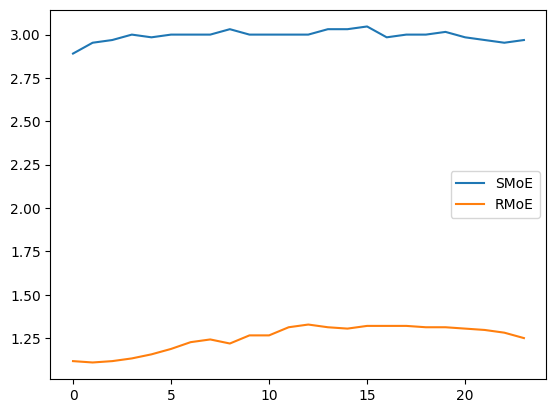

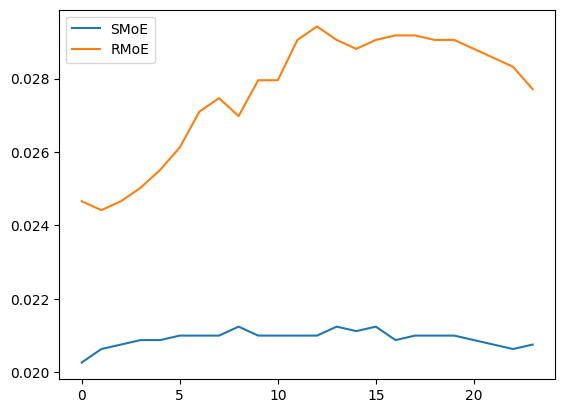

In [10]:
SMoE_router_weights = [SMoE_model['model.layers.{i}.block_sparse_moe.gate.weight'.format(i=i)] for i in range(24)]
RMoE_router_weights = [RMoE_model['model.layers.{i}.block_sparse_moe.weight2'.format(i=i)] for i in range(24)]

# 统计 weights 的 norm 和 std ， 并画图

SMoE_router_weights_norm = [torch.norm(w).item() for w in SMoE_router_weights]
RMoE_router_weights_norm = [torch.norm(w).item() for w in RMoE_router_weights]
SMoE_router_weights_std = [torch.std(w).item() for w in SMoE_router_weights]
RMoE_router_weights_std = [torch.std(w).item() for w in RMoE_router_weights]
plt.plot(SMoE_router_weights_norm, label='SMoE')
plt.plot(RMoE_router_weights_norm, label='RMoE')
plt.legend()
plt.show()
plt.plot(SMoE_router_weights_std, label='SMoE')
plt.plot(RMoE_router_weights_std, label='RMoE')
plt.legend()
plt.show()


In [11]:
def get_similarities(htoh4_0, htoh4_1, h4toh):
    avg_key_0 = htoh4_0.mean(dim=1) # (num_experts, 4h, h)
    avg_key_1 = htoh4_1.mean(dim=1) # (num_experts, 4h, h)
    avg_value = h4toh.mean(dim=2) # (num_experts, h, 4h)
    normed_key_0 = nn.functional.normalize(avg_key_0, p=2, dim=1)
    normed_key_1 = nn.functional.normalize(avg_key_1, p=2, dim=1)
    normed_value = nn.functional.normalize(avg_value, p=2, dim=1)
    normed_avg_expert = torch.cat([normed_key_0, normed_key_1, normed_value], dim=1)
    avg_expert = torch.cat([avg_key_0, avg_key_1, avg_value], dim=1)
    # 计算 experts 间的平均相似度
    similarity = torch.mm(avg_expert, avg_expert.t()) 
    avg_sim = similarity.mean().item()

    normed_similarity = torch.mm(normed_avg_expert, normed_avg_expert.t())
    normed_avg_sim = normed_similarity.mean().item()
    return avg_sim, normed_avg_sim

In [ ]:
def get_similarities(htoh4_0, htoh4_1, h4toh):
    avg_key_0 = htoh4_0.mean(dim=1) # (num_experts, 4h, h)
    avg_key_1 = htoh4_1.mean(dim=1) # (num_experts, 4h, h)
    avg_value = h4toh.mean(dim=2) # (num_experts, h, 4h)
    normed_key_0 = nn.functional.normalize(avg_key_0, p=2, dim=1)
    normed_key_1 = nn.functional.normalize(avg_key_1, p=2, dim=1)
    normed_value = nn.functional.normalize(avg_value, p=2, dim=1)
    normed_avg_expert = torch.cat([normed_key_0, normed_key_1, normed_value], dim=1)
    # compute the average expert similarity
    normed_similarity = torch.mm(normed_avg_expert, normed_avg_expert.t())
    normed_avg_sim = normed_similarity.mean().item()
    return  normed_avg_sim




In [25]:
SMoE_expert_weights = []
RMoE_expert_weights = []
for i in range(24):
        SMoE_w1 = torch.cat([SMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w1.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
        SMoE_w2 = torch.cat([SMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w2.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
        SMoE_w3 = torch.cat([SMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w3.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
        
        RMoE_w1 = torch.cat([RMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w1.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
        RMoE_w2 = torch.cat([RMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w2.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
        RMoE_w3 = torch.cat([RMoE_model['model.layers.{i}.block_sparse_moe.experts.{j}.w3.weight'.format(i=i, j=j)].unsqueeze(0) for j in range(16)], dim=0)
                            
        SMoE_expert_weights.append((SMoE_w1, SMoE_w3, SMoE_w2))
        RMoE_expert_weights.append((RMoE_w1, RMoE_w3, RMoE_w2))

SMoE_expert_sims = [get_similarities(*w) for w in SMoE_expert_weights]
RMoE_expert_sims = [get_similarities(*w) for w in RMoE_expert_weights]

SMoE_normed_sims = [x[1] for x in SMoE_expert_sims]
RMoE_normed_sims = [x[1] for x in RMoE_expert_sims]

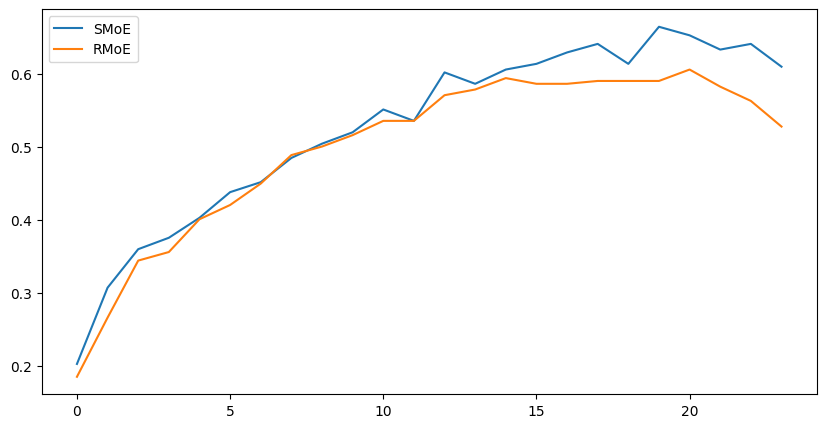

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(SMoE_normed_sims, label='SMoE')
plt.plot(RMoE_normed_sims, label='RMoE')
plt.legend()


In [18]:
ckpt_infos = torch.load('./megatron_ckpt_infos.pth')

In [19]:
ckpt_infos.keys()

dict_keys(['01000', '02000', '03000', '04000', '05000', '06000', '07000', '08000', '09000', '10000'])

In [20]:
ckpt_infos['10000'].keys()

dict_keys(['SMoE_router_weights_norm', 'RMoE_router_weights_norm', 'SMoE_router_weights_std', 'RMoE_router_weights_std', 'SMoE_expert_sims', 'RMoE_expert_sims'])

In [21]:
# baseline similarity; std = 0.02
experts_w1 = torch.randn(16, 448, 1280) * 0.02
experts_w2 = torch.randn(16, 1280, 448) * 0.02
experts_w3 = torch.randn(16, 448, 1280) * 0.02

print(get_similarities(experts_w1, experts_w3, experts_w2))

(0.00021328969160094857, 0.18557727336883545)


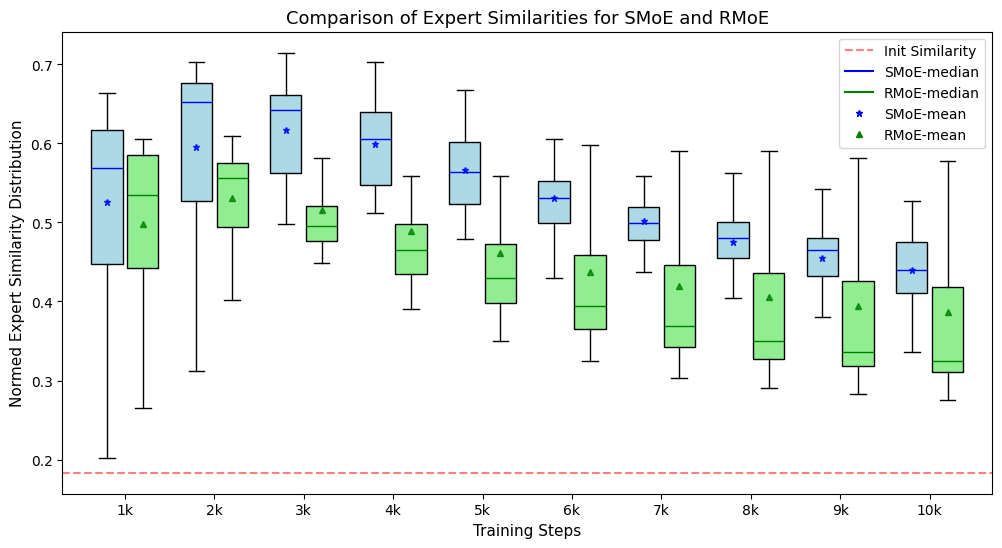

In [9]:

# 绘制箱型图
# x 轴为不同的 checkpoint
# y 轴为不同层 expert similarity 的箱型图表示

SMoE_expert_sims = [ckpt_infos[ckpt]['SMoE_expert_sims'] for ckpt in ckpt_infos]
RMoE_expert_sims = [ckpt_infos[ckpt]['RMoE_expert_sims'] for ckpt in ckpt_infos]

SMoE_expert_sims = np.array(SMoE_expert_sims).T
RMoE_expert_sims = np.array(RMoE_expert_sims).T


# 绘制箱线图
plt.figure(figsize=(12, 6))

# 箱线图的位置稍微错开
positions_SMoE = np.arange(10) - 0.2
positions_RMoE = np.arange(10) + 0.2

# 绘制SMoE的箱线图
plt.boxplot(SMoE_expert_sims, positions=positions_SMoE, showfliers=False, patch_artist=True, showmeans=True,  
            meanprops=dict(marker='*', markerfacecolor='blue', markersize=5, linestyle='None', color='blue', markeredgecolor='blue', alpha=0.8),
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'), widths=0.35)
# 绘制RMoE的箱线图
plt.boxplot(RMoE_expert_sims, positions=positions_RMoE, showfliers=False, patch_artist=True, showmeans=True, 
            meanprops=dict(marker='^', markerfacecolor='green', markersize=5, linestyle='None', color='green', markeredgecolor='green', alpha=0.8),
            boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='green'), widths=0.35)

# 添加水平线，基准 similarity
plt.axhline(y=0.1833, color='red', linestyle='--', label='Init Similarity', alpha=0.5)

# 添加图例
plt.plot([], c='blue', label='SMoE-median')
plt.plot([], c='green', label='RMoE-median')
# 添加 means 标注的图例(三角形)
plt.plot([], c='blue', marker='*', label='SMoE-mean', linestyle='None', markersize=5)
plt.plot([], c='green', marker='^', label='RMoE-mean', linestyle='None', markersize=5)
plt.legend()

# 添加标签
plt.xlabel('Training Steps', fontsize=11)
plt.ylabel('Normed Expert Similarity Distribution', fontsize=11)
plt.title('Comparison of Expert Similarities for SMoE and RMoE', fontsize=13)


plt.xticks(range(10), [f'{j}k' for j in range(1, 11)])

# 显示图表
plt.savefig('expert_similarity.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()


In [14]:
# 
# random_gate_norm = (torch.randn(8, 128) * 0.02).norm().item()

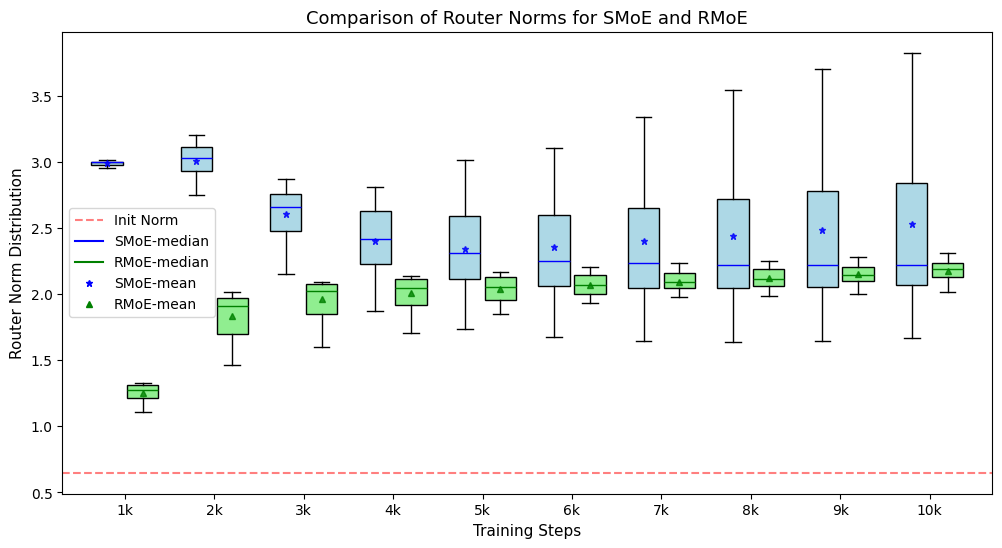

In [16]:
# 绘制箱型图
# x 轴为不同的 checkpoint
# y 轴为不同层 router norms 的箱型图表示

SMoE_router_weights_norm = [ckpt_infos[ckpt]['SMoE_router_weights_norm'] for ckpt in ckpt_infos]
RMoE_router_weights_norm = [ckpt_infos[ckpt]['RMoE_router_weights_norm'] for ckpt in ckpt_infos]

SMoE_router_weights_norm = np.array(SMoE_router_weights_norm).T
RMoE_router_weights_norm = np.array(RMoE_router_weights_norm).T

# 绘制箱线图
plt.figure(figsize=(12, 6))

# 箱线图的位置稍微错开
positions_SMoE = np.arange(10) - 0.2
positions_RMoE = np.arange(10) + 0.2

# 绘制SMoE的箱线图
plt.boxplot(SMoE_router_weights_norm, positions=positions_SMoE, showfliers=False, patch_artist=True, showmeans=True,  
            meanprops=dict(marker='*', markerfacecolor='blue', markersize=5, linestyle='None', color='blue', markeredgecolor='blue', alpha=0.8),
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'), widths=0.35)
# 绘制RMoE的箱线图
plt.boxplot(RMoE_router_weights_norm, positions=positions_RMoE, showfliers=False, patch_artist=True, showmeans=True, 
            meanprops=dict(marker='^', markerfacecolor='green', markersize=5, linestyle='None', color='green', markeredgecolor='green', alpha=0.8),
            boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='green'), widths=0.35)

plt.axhline(y=random_gate_norm, color='red', linestyle='--', label='Init Norm', alpha=0.5)

# 添加图例
plt.plot([], c='blue', label='SMoE-median')
plt.plot([], c='green', label='RMoE-median')
# 添加 means 标注的图例(三角形)
plt.plot([], c='blue', marker='*', label='SMoE-mean', linestyle='None', markersize=5)
plt.plot([], c='green', marker='^', label='RMoE-mean', linestyle='None', markersize=5)

plt.legend()

# 添加标签
plt.xlabel('Training Steps', fontsize=11)
plt.ylabel('Router Norm Distribution', fontsize=11)
plt.title('Comparison of Router Norms for SMoE and RMoE', fontsize=13)

plt.xticks(range(10), [f'{j}k' for j in range(1, 11)])

# 显示图表
plt.savefig('router_norm.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()
